In [5]:
using KomaMRI, Plots, Unitful

seq = read_seq("mpf_001_short.seq")

function simulate_slice_profile_x(
    seq::Sequence; x=range(-2.e-2, 2.e-2, 200), sim_params=Dict{String,Any}("Δt_rf" => 1e-6)
)
    sim_params["return_type"] = "state"
    sys = Scanner()
    obj = Phantom{Float64}(; x=Array(x), z=zeros(size(x)))
    mag = simulate(obj, seq, sys; sim_params)
    return mag
end

┌ Info: Loading sequence mpf_001_short.seq ...
└ @ KomaMRIFiles C:\Users\lucya\.julia\packages\KomaMRIFiles\Xc9Fh\src\Sequence\Pulseq.jl:339


simulate_slice_profile_x (generic function with 1 method)

In [ ]:
length(seq)
size(seq.RF)  # returns (n_rf_blocks_per_pulse, n_rf_pulses)

for i in 1:size(seq.RF, 2)
    if any(rf -> !iszero(rf.A), seq.RF[:, i])
        println("Nonzero RF at index $i")
    end
end

count(i -> any(rf -> !iszero(rf.A), seq.RF[:, i]), 1:size(seq.RF, 2))





In [6]:
begin

    # Define spatial domain (slice direction: x)
    x = -0.01:0.0001:0.01  # ±10 mm
    Δx = x[2] - x[1]
    slice_thickness = 10e-3  # in meters

    # Pick RF pulse event to test (e.g., 1035)
    rf_event = seq[1035]

    # Simulate slice profile along x
    M = simulate_slice_profile_x(rf_event; x=x)

    # Use M.xy directly (complex: Mx + iMy)
    Mxy = M.xy

    # Integrate across x and compute magnitude
    integral_Mxy = sum(Mxy) * Δx
    magnitude_integral = abs(integral_Mxy)

    # Theoretical expectation: sin(FA) × slice thickness
    #nominal_fa_deg = 30  # set this to the actual FA for rf_event
    #nominal_fa_rad = deg2rad(nominal_fa_deg)
    #expected = sin(nominal_fa_rad) * slice_thickness

    # Print comparison
    println("Bloch result (|∫ Mxy dx|): ", round(magnitude_integral, sigdigits=5))
    #println("Expected = sin(fa) × thickness: ", round(expected, sigdigits=5))
    #println("Relative error: ", round(100 * abs(magnitude_integral - expected) / expected, digits=2), "%")

    # Plot slice profile
    #display(Plots.plot(x .* 1e3, abs.(Mxy), xlabel="x (mm)", ylabel="|Mxy|", title="Transverse Slice Profile"))
    

    actual_fa_rad = asin(clamp(magnitude_integral / slice_thickness, -1.0, 1.0))
    actual_fa_deg = actual_fa_rad * 180 / π
    println("Actual FA from Bloch: ", round(actual_fa_deg, digits=2), "°")

end



  0.065576 seconds (150.99 k allocations: 7.563 MiB)
Bloch result (|∫ Mxy dx|): 0.0044634
Actual FA from Bloch: 26.51°


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


In [7]:
begin

    fa_degrees = Float64[]
    rf_indices = Int[]

    # Define spatial domain (slice direction: x)
    x = -0.01:0.0001:0.01  # ±10 mm
    Δx = x[2] - x[1]
    slice_thickness = 10e-3  # in meters

    for i in 1:length(seq)
        rf_blocks = seq.RF[:, i]
        if all(rf -> iszero(rf.A), rf_blocks)
            continue  # skip if RF amplitude is zero
        end

        rf_event = seq[i]  # wrap the single SequenceEvent


        # Simulate slice profile along x
        M = simulate_slice_profile_x(rf_event; x=x)

        # Use M.xy directly (complex: Mx + iMy)
        Mxy = M.xy

        # # Integrate across x and compute magnitude
        integral_Mxy = sum(Mxy) * Δx
        magnitude_integral = abs(integral_Mxy)

        α_rad = asin(clamp(magnitude_integral / slice_thickness, -1.0, 1.0))
        α_deg = α_rad * 180 / π

        push!(fa_degrees, α_deg)
        push!(rf_indices, i)







        # # Print comparison
        # println("Bloch result (|∫ Mxy dx|): ", round(magnitude_integral, sigdigits=5))
        

        # actual_fa_rad = asin(clamp(magnitude_integral / slice_thickness, -1.0, 1.0))
        # actual_fa_deg = actual_fa_rad * 180 / π
        # println("Actual FA from Bloch: ", round(actual_fa_deg, digits=2), "°")

    end

end



┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 6406
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  36%|███████████                   |  ETA: 0:00:00


Running simulation...  68%|█████████████████████         |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 22
          rf_blocks: 20
        acq_samples: 0


  0.316632 seconds (921.75 k allocations: 45.396 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.061373 seconds (151.51 k allocations: 7.620 MiB)
  0.056230 seconds (151.51 k allocations: 7.620 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.066623 seconds (151.63 k allocations: 7.626 MiB, 32.79% gc time)
  0.094339 seconds (151.64 k allocations: 7.626 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.062816 seconds (151.76 k allocations: 7.631 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.036690 seconds (151.76 k allocations: 7.631 MiB)
  0.046761 seconds (151.76 k allocations: 7.631 MiB)
  0.037050 seconds (151.76 k allocations: 7.631 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.038537 seconds (151.76 k allocations: 7.631 MiB)
  0.059310 seconds (151.76 k allocations: 7.631 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.076842 seconds (151.76 k allocations: 7.631 MiB, 24.67% gc time)
  0.079462 seconds (151.76 k allocations: 7.631 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.068480 seconds (151.76 k allocations: 7.631 MiB)
  0.078450 seconds (151.76 k allocations: 7.631 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.062074 seconds (151.76 k allocations: 7.631 MiB)
  0.036965 seconds (151.88 k allocations: 7.637 MiB)
  0.041293 seconds (151.88 k allocations: 7.637 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.044053 seconds (151.88 k allocations: 7.637 MiB)
  0.060414 seconds (151.88 k allocations: 7.637 MiB, 26.43% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.046879 seconds (151.88 k allocations: 7.637 MiB)
  0.057129 seconds (151.88 k allocations: 7.637 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.055714 seconds (151.88 k allocations: 7.637 MiB)
  0.053457 seconds (151.88 k allocations: 7.637 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.049647 seconds (151.88 k allocations: 7.637 MiB)
  0.034575 seconds (151.88 k allocations: 7.637 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.061422 seconds (151.88 k allocations: 7.637 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.098890 seconds (151.88 k allocations: 7.637 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  88%|███████████████████████████   |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.122537 seconds (152.60 k allocations: 7.674 MiB, 22.28% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.097717 seconds (151.88 k allocations: 7.637 MiB)
  0.072121 seconds (151.88 k allocations: 7.637 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.084252 seconds (151.88 k allocations: 7.637 MiB)
  0.065983 seconds (151.88 k allocations: 7.637 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.073242 seconds (151.88 k allocations: 7.637 MiB)
  0.046086 seconds (151.88 k allocations: 7.637 MiB)
  0.040889 seconds (151.88 k allocations: 7.637 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.053081 seconds (151.88 k allocations: 7.637 MiB, 23.23% gc time)
  0.037455 seconds (151.88 k allocations: 7.637 MiB)
  0.046466 seconds (151.88 k allocations: 7.637 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.053701 seconds (151.88 k allocations: 7.637 MiB)
  0.042821 seconds (151.88 k allocations: 7.637 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.067779 seconds (151.42 k allocations: 7.599 MiB)
  0.074626 seconds (151.42 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.040600 seconds (151.41 k allocations: 7.599 MiB)
  0.070329 seconds (151.41 k allocations: 7.599 MiB, 19.12% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.043955 seconds (151.41 k allocations: 7.599 MiB)
  0.081399 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.078741 seconds (151.42 k allocations: 7.599 MiB)
  0.054694 seconds (151.42 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.073634 seconds (151.41 k allocations: 7.599 MiB)
  0.068183 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.059520 seconds (151.42 k allocations: 7.599 MiB)
  0.069907 seconds (151.42 k allocations: 7.599 MiB, 17.00% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.045885 seconds (151.42 k allocations: 7.599 MiB)
  0.033188 seconds (151.42 k allocations: 7.599 MiB)
  0.038021 seconds (151.42 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.036635 seconds (151.41 k allocations: 7.599 MiB)
  0.033117 seconds (151.42 k allocations: 7.599 MiB)
  0.042942 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.062567 seconds (151.41 k allocations: 7.599 MiB)
  0.047643 seconds (151.42 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.081789 seconds (151.42 k allocations: 7.599 MiB, 25.25% gc time)
  0.072368 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.045578 seconds (151.41 k allocations: 7.599 MiB)
  0.077895 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.075295 seconds (151.41 k allocations: 7.599 MiB)
  0.053279 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.047089 seconds (151.42 k allocations: 7.599 MiB)
  0.061137 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.069868 seconds (151.42 k allocations: 7.599 MiB, 19.57% gc time)
  0.054175 seconds (151.42 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.046471 seconds (151.41 k allocations: 7.599 MiB)
  0.048625 seconds (151.41 k allocations: 7.599 MiB)
  0.041720 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.057572 seconds (151.42 k allocations: 7.599 MiB)
  0.049381 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.065665 seconds (151.41 k allocations: 7.599 MiB)
  0.076359 seconds (151.42 k allocations: 7.599 MiB, 20.43% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.050583 seconds (151.42 k allocations: 7.599 MiB)
  0.074597 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.083264 seconds (151.42 k allocations: 7.599 MiB)
  0.077291 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.079792 seconds (151.41 k allocations: 7.599 MiB)
  0.073576 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.064774 seconds (151.41 k allocations: 7.599 MiB)
  0.030615 seconds (151.42 k allocations: 7.599 MiB)
  0.047201 seconds (151.42 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.030973 seconds (151.42 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.090567 seconds (151.42 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  83%|██████████████████████████    |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  0.118624 seconds (152.12 k allocations: 7.635 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.088290 seconds (151.41 k allocations: 7.599 MiB)
  0.041168 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.077230 seconds (151.41 k allocations: 7.599 MiB)
  0.049845 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.075386 seconds (151.42 k allocations: 7.599 MiB, 25.57% gc time)
  0.062169 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.063749 seconds (151.42 k allocations: 7.599 MiB)
  0.068457 seconds (151.42 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.039327 seconds (151.41 k allocations: 7.599 MiB)
  0.043611 seconds (151.42 k allocations: 7.599 MiB)
  0.035452 seconds (151.42 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.040606 seconds (151.42 k allocations: 7.599 MiB)
  0.042542 seconds (151.42 k allocations: 7.599 MiB, 25.39% gc time)
  0.039668 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.043053 seconds (151.42 k allocations: 7.599 MiB)
  0.047170 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.063552 seconds (151.41 k allocations: 7.599 MiB)
  0.071776 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.073371 seconds (151.41 k allocations: 7.599 MiB)
  0.064950 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.103346 seconds (151.41 k allocations: 7.599 MiB, 17.69% gc time)
  0.055871 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.038578 seconds (151.41 k allocations: 7.599 MiB)
  0.062168 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.049866 seconds (151.41 k allocations: 7.599 MiB)
  0.060849 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.043713 seconds (151.41 k allocations: 7.599 MiB)
  0.041409 seconds (151.42 k allocations: 7.599 MiB)
  0.042416 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.062236 seconds (151.42 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.062582 seconds (151.42 k allocations: 7.599 MiB)
  0.039369 seconds (151.42 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.065831 seconds (151.41 k allocations: 7.599 MiB)
  0.069170 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.054525 seconds (151.41 k allocations: 7.599 MiB)
  0.050648 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.061550 seconds (151.41 k allocations: 7.599 MiB)
  0.083325 seconds (151.42 k allocations: 7.599 MiB, 27.26% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.046755 seconds (151.41 k allocations: 7.599 MiB)
  0.033737 seconds (151.41 k allocations: 7.599 MiB)
  0.032679 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.046048 seconds (151.42 k allocations: 7.599 MiB)
  0.033539 seconds (151.41 k allocations: 7.599 MiB)
  0.033958 seconds (151.42 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.036395 seconds (151.41 k allocations: 7.599 MiB)
  0.048254 seconds (151.42 k allocations: 7.599 MiB, 26.45% gc time)
  0.040001 seconds (151.42 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.037097 seconds (151.41 k allocations: 7.599 MiB)
  0.032300 seconds (151.42 k allocations: 7.599 MiB)
  0.045016 seconds (151.42 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.048060 seconds (151.42 k allocations: 7.599 MiB)
  0.036077 seconds (151.42 k allocations: 7.599 MiB)
  0.057499 seconds (151.42 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.070012 seconds (151.41 k allocations: 7.599 MiB, 27.92% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.052684 seconds (151.41 k allocations: 7.599 MiB)
  0.041661 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.063510 seconds (151.42 k allocations: 7.599 MiB)
  0.044111 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.057907 seconds (151.42 k allocations: 7.599 MiB)
  0.063298 seconds (151.42 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.038596 seconds (151.41 k allocations: 7.599 MiB)
  0.035567 seconds (151.41 k allocations: 7.599 MiB)
  0.054736 seconds (151.42 k allocations: 7.599 MiB, 22.98% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.059392 seconds (151.42 k allocations: 7.599 MiB)
  0.055240 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.053886 seconds (151.41 k allocations: 7.599 MiB)
  0.040654 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.057680 seconds (151.41 k allocations: 7.599 MiB)
  0.057168 seconds (151.42 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.043126 seconds (151.42 k allocations: 7.599 MiB)
  0.055162 seconds (151.88 k allocations: 7.637 MiB, 25.58% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.046507 seconds (151.88 k allocations: 7.637 MiB)
  0.069830 seconds (151.88 k allocations: 7.637 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.106262 seconds (151.88 k allocations: 7.637 MiB)
  0.046259 seconds (151.88 k allocations: 7.637 MiB)
  0.037661 seconds (151.88 k allocations: 7.637 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.042514 seconds (151.88 k allocations: 7.637 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.096585 seconds (151.88 k allocations: 7.637 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  85%|██████████████████████████    |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.111805 seconds (152.53 k allocations: 7.671 MiB, 15.64% gc time)
  0.063887 seconds (151.88 k allocations: 7.637 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.041040 seconds (151.88 k allocations: 7.637 MiB)
  0.040396 seconds (151.88 k allocations: 7.637 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.092799 seconds (151.88 k allocations: 7.637 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  46%|██████████████                |  ETA: 0:00:00


Running simulation...  85%|██████████████████████████    |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.443142 seconds (152.86 k allocations: 7.685 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  27%|█████████                     |  ETA: 0:00:00


Running simulation...  42%|█████████████                 |  ETA: 0:00:00


Running simulation...  69%|█████████████████████         |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.515142 seconds (153.13 k allocations: 7.696 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  50%|████████████████              |  ETA: 0:00:00


Running simulation...  85%|██████████████████████████    |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.426828 seconds (152.85 k allocations: 7.685 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:00


Running simulation...  65%|████████████████████          |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.651464 seconds (152.84 k allocations: 7.684 MiB, 5.27% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:00


Running simulation...  73%|██████████████████████        |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.455580 seconds (152.88 k allocations: 7.686 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:00


Running simulation...  62%|███████████████████           |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.432350 seconds (152.84 k allocations: 7.684 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  54%|█████████████████             |  ETA: 0:00:00


Running simulation...  96%|█████████████████████████████ |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.407275 seconds (152.86 k allocations: 7.685 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:00


Running simulation...  69%|█████████████████████         |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.494389 seconds (152.78 k allocations: 7.682 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  54%|█████████████████             |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.329722 seconds (152.53 k allocations: 7.669 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:00


Running simulation...  58%|██████████████████            |  ETA: 0:00:00


Running simulation...  77%|████████████████████████      |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.609337 seconds (153.17 k allocations: 7.697 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  58%|██████████████████            |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.255295 seconds (152.54 k allocations: 7.671 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  31%|██████████                    |  ETA: 0:00:00


Running simulation...  46%|██████████████                |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:01
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  1.208321 seconds (153.02 k allocations: 7.693 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  38%|████████████                  |  ETA: 0:00:00


Running simulation...  65%|████████████████████          |  ETA: 0:00:00


Running simulation...  85%|██████████████████████████    |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.563761 seconds (153.01 k allocations: 7.692 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:00


Running simulation...  62%|███████████████████           |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.446164 seconds (152.77 k allocations: 7.681 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:00


Running simulation...  88%|███████████████████████████   |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.818465 seconds (152.79 k allocations: 7.684 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  19%|██████                        |  ETA: 0:00:01


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.409829 seconds (152.54 k allocations: 7.669 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  54%|█████████████████             |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.353231 seconds (152.43 k allocations: 7.666 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  62%|███████████████████           |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.218965 seconds (152.42 k allocations: 7.665 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  69%|█████████████████████         |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.183261 seconds (152.41 k allocations: 7.665 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  73%|██████████████████████        |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.188715 seconds (152.41 k allocations: 7.665 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  50%|████████████████              |  ETA: 0:00:00


Running simulation...  88%|███████████████████████████   |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.419456 seconds (152.74 k allocations: 7.679 MiB, 5.25% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  38%|████████████                  |  ETA: 0:00:00


Running simulation...  62%|███████████████████           |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.421254 seconds (152.72 k allocations: 7.677 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  73%|██████████████████████        |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.173319 seconds (152.41 k allocations: 7.665 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:00


Running simulation...  77%|████████████████████████      |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.365228 seconds (152.59 k allocations: 7.673 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  31%|██████████                    |  ETA: 0:00:00


Running simulation...  50%|████████████████              |  ETA: 0:00:00


Running simulation...  88%|███████████████████████████   |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.433230 seconds (152.92 k allocations: 7.687 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.901483 seconds (152.38 k allocations: 7.664 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  77%|████████████████████████      |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.171438 seconds (152.28 k allocations: 7.659 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:00


Running simulation...  65%|████████████████████          |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.436603 seconds (152.46 k allocations: 7.667 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:00


Running simulation...  65%|████████████████████          |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.444929 seconds (152.61 k allocations: 7.673 MiB, 22.86% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  65%|████████████████████          |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.197017 seconds (152.28 k allocations: 7.659 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  54%|█████████████████             |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.340063 seconds (152.23 k allocations: 7.657 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:00


Running simulation...  73%|██████████████████████        |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.404732 seconds (152.71 k allocations: 7.678 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  69%|█████████████████████         |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.192107 seconds (152.35 k allocations: 7.662 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  69%|█████████████████████         |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.278116 seconds (152.38 k allocations: 7.663 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:00


Running simulation...  73%|██████████████████████        |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.411985 seconds (152.74 k allocations: 7.679 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  50%|████████████████              |  ETA: 0:00:00


Running simulation...  96%|█████████████████████████████ |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.235552 seconds (152.75 k allocations: 7.680 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  73%|██████████████████████        |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.298807 seconds (152.42 k allocations: 7.665 MiB, 8.73% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:00


Running simulation...  73%|██████████████████████        |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.400110 seconds (152.74 k allocations: 7.679 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:00


Running simulation...  96%|█████████████████████████████ |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.268797 seconds (152.73 k allocations: 7.679 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  69%|█████████████████████         |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.272784 seconds (152.40 k allocations: 7.665 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:01


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.967776 seconds (152.59 k allocations: 7.673 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  38%|████████████                  |  ETA: 0:00:00


Running simulation...  62%|███████████████████           |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.417144 seconds (152.86 k allocations: 7.685 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:00


Running simulation...  81%|█████████████████████████     |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.268622 seconds (152.82 k allocations: 7.684 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  62%|███████████████████           |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.234981 seconds (152.55 k allocations: 7.671 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:00


Running simulation...  77%|████████████████████████      |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.429709 seconds (152.84 k allocations: 7.684 MiB, 9.84% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:00


Running simulation...  81%|█████████████████████████     |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.294466 seconds (152.85 k allocations: 7.685 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  58%|██████████████████            |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.218685 seconds (152.52 k allocations: 7.671 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:00


Running simulation...  69%|█████████████████████         |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.427853 seconds (152.85 k allocations: 7.684 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:00


Running simulation...  77%|████████████████████████      |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.317013 seconds (152.82 k allocations: 7.684 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  81%|█████████████████████████     |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.132062 seconds (152.54 k allocations: 7.671 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:00


Running simulation...  77%|████████████████████████      |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.321665 seconds (152.84 k allocations: 7.685 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  50%|████████████████              |  ETA: 0:00:00


Running simulation...  92%|████████████████████████████  |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.296818 seconds (152.85 k allocations: 7.685 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  62%|███████████████████           |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.187373 seconds (152.52 k allocations: 7.670 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  54%|█████████████████             |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.203355 seconds (152.59 k allocations: 7.674 MiB, 13.36% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:01


Running simulation...  81%|█████████████████████████     |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.727080 seconds (152.84 k allocations: 7.684 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  58%|██████████████████            |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.251023 seconds (152.56 k allocations: 7.671 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  42%|█████████████                 |  ETA: 0:00:00


Running simulation...  69%|█████████████████████         |  ETA: 0:00:00


Running simulation...  92%|████████████████████████████  |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.610769 seconds (153.21 k allocations: 7.701 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  88%|███████████████████████████   |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 26
          rf_blocks: 22
        acq_samples: 0


  0.120078 seconds (152.49 k allocations: 7.671 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.092325 seconds (151.88 k allocations: 7.637 MiB)
  0.074776 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.106402 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  71%|██████████████████████        |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  0.131532 seconds (152.10 k allocations: 7.634 MiB, 18.16% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385


  0.176288 seconds (151.41 k allocations: 7.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  46%|██████████████                |  ETA: 0:00:00


Running simulation...  79%|████████████████████████      |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  0.418903 seconds (152.38 k allocations: 7.646 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  46%|██████████████                |  ETA: 0:00:00


Running simulation...  75%|███████████████████████       |  ETA: 0:00:00


Running simulation...  96%|█████████████████████████████ |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  0.593989 seconds (152.75 k allocations: 7.663 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  33%|███████████                   |  ETA: 0:00:00


Running simulation...  54%|█████████████████             |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  0.502477 seconds (152.36 k allocations: 7.646 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  46%|██████████████                |  ETA: 0:00:00


Running simulation...  83%|██████████████████████████    |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  0.431461 seconds (152.37 k allocations: 7.646 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  46%|██████████████                |  ETA: 0:00:00


Running simulation...  75%|███████████████████████       |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  0.394556 seconds (152.33 k allocations: 7.644 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  50%|████████████████              |  ETA: 0:00:00


Running simulation...  96%|█████████████████████████████ |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  0.814591 seconds (152.53 k allocations: 7.655 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  46%|██████████████                |  ETA: 0:00:00


Running simulation...  71%|██████████████████████        |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:01
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  1.226457 seconds (152.54 k allocations: 7.656 MiB, 13.43% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  46%|██████████████                |  ETA: 0:00:00


Running simulation...  83%|██████████████████████████    |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  0.395934 seconds (152.39 k allocations: 7.647 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  46%|██████████████                |  ETA: 0:00:00


Running simulation...  71%|██████████████████████        |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  0.479776 seconds (152.42 k allocations: 7.649 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  46%|██████████████                |  ETA: 0:00:00


Running simulation...  75%|███████████████████████       |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  0.323802 seconds (152.37 k allocations: 7.646 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  46%|██████████████                |  ETA: 0:00:00


Running simulation...  67%|█████████████████████         |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  0.496395 seconds (152.27 k allocations: 7.643 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  46%|██████████████                |  ETA: 0:00:00


Running simulation...  92%|████████████████████████████  |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  0.275333 seconds (152.38 k allocations: 7.647 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  50%|████████████████              |  ETA: 0:00:00


Running simulation...  92%|████████████████████████████  |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  0.383788 seconds (152.37 k allocations: 7.646 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  46%|██████████████                |  ETA: 0:00:00


Running simulation...  71%|██████████████████████        |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  0.491156 seconds (152.38 k allocations: 7.646 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  46%|██████████████                |  ETA: 0:00:00


Running simulation...  88%|███████████████████████████   |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  0.367933 seconds (152.36 k allocations: 7.647 MiB, 23.40% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  46%|██████████████                |  ETA: 0:00:00


Running simulation...  67%|█████████████████████         |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  0.572485 seconds (152.39 k allocations: 7.646 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  46%|██████████████                |  ETA: 0:00:00


Running simulation...  83%|██████████████████████████    |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  0.265022 seconds (152.36 k allocations: 7.646 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  46%|██████████████                |  ETA: 0:00:00


Running simulation...  62%|███████████████████           |  ETA: 0:00:00


Running simulation...  88%|███████████████████████████   |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  0.762122 seconds (152.69 k allocations: 7.660 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  46%|██████████████                |  ETA: 0:00:00


Running simulation...  75%|███████████████████████       |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  0.668716 seconds (152.36 k allocations: 7.644 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  46%|██████████████                |  ETA: 0:00:00


Running simulation...  67%|█████████████████████         |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  0.419278 seconds (152.36 k allocations: 7.646 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  46%|██████████████                |  ETA: 0:00:00


Running simulation...  58%|██████████████████            |  ETA: 0:00:00


Running simulation...  75%|███████████████████████       |  ETA: 0:00:00


Running simulation...  92%|████████████████████████████  |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  0.897780 seconds (153.01 k allocations: 7.674 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  46%|██████████████                |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:01
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  1.094521 seconds (152.21 k allocations: 7.639 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  46%|██████████████                |  ETA: 0:00:00


Running simulation...  62%|███████████████████           |  ETA: 0:00:00


Running simulation...  75%|███████████████████████       |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 24
          rf_blocks: 21
        acq_samples: 0


  0.822264 seconds (152.74 k allocations: 7.662 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  18%|██████                        |  ETA: 0:00:00


Running simulation...  64%|████████████████████          |  ETA: 0:00:00


Running simulation...  82%|█████████████████████████     |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 22
          rf_blocks: 20
        acq_samples: 0


  0.688921 seconds (152.26 k allocations: 7.623 MiB, 6.77% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  18%|██████                        |  ETA: 0:00:01


Running simulation...  27%|█████████                     |  ETA: 0:00:01


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 22
          rf_blocks: 20
        acq_samples: 0


  0.459969 seconds (151.94 k allocations: 7.607 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...   9%|███                           |  ETA: 0:00:01


Running simulation...  18%|██████                        |  ETA: 0:00:01


Running simulation...  32%|██████████                    |  ETA: 0:00:01


Running simulation...  45%|██████████████                |  ETA: 0:00:01


Running simulation...  73%|██████████████████████        |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 22
          rf_blocks: 20
        acq_samples: 0


  0.880918 seconds (152.98 k allocations: 7.654 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  18%|██████                        |  ETA: 0:00:01


Running simulation... 100%|██████████████████████████████| Time: 0:00:01
   simulated_blocks: 22
          rf_blocks: 20
        acq_samples: 0


  1.443424 seconds (151.88 k allocations: 7.609 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  14%|█████                         |  ETA: 0:00:01


Running simulation...  18%|██████                        |  ETA: 0:00:01


Running simulation...  64%|████████████████████          |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 22
          rf_blocks: 20
        acq_samples: 0


  0.708263 seconds (152.30 k allocations: 7.624 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  18%|██████                        |  ETA: 0:00:01


Running simulation...  27%|█████████                     |  ETA: 0:00:01


Running simulation...  73%|██████████████████████        |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 22
          rf_blocks: 20
        acq_samples: 0


  0.708109 seconds (152.17 k allocations: 7.620 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  32%|██████████                    |  ETA: 0:00:00


Running simulation...  55%|█████████████████             |  ETA: 0:00:00


Running simulation...  73%|██████████████████████        |  ETA: 0:00:00


Running simulation...  95%|█████████████████████████████ |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 22
          rf_blocks: 20
        acq_samples: 0


  0.904540 seconds (152.61 k allocations: 7.638 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  27%|█████████                     |  ETA: 0:00:00


Running simulation...  50%|████████████████              |  ETA: 0:00:00


Running simulation...  91%|████████████████████████████  |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 22
          rf_blocks: 20
        acq_samples: 0


  0.713330 seconds (152.30 k allocations: 7.625 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  18%|██████                        |  ETA: 0:00:01


Running simulation...  73%|██████████████████████        |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 22
          rf_blocks: 20
        acq_samples: 0


  0.690024 seconds (151.95 k allocations: 7.610 MiB, 5.28% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  18%|██████                        |  ETA: 0:00:01


Running simulation...  27%|█████████                     |  ETA: 0:00:01


Running simulation...  55%|█████████████████             |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 22
          rf_blocks: 20
        acq_samples: 0


  0.637882 seconds (152.24 k allocations: 7.621 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  23%|███████                       |  ETA: 0:00:00


Running simulation...  36%|███████████                   |  ETA: 0:00:01


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 22
          rf_blocks: 20
        acq_samples: 0


  0.746500 seconds (151.96 k allocations: 7.610 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  23%|███████                       |  ETA: 0:00:00


Running simulation...  59%|██████████████████            |  ETA: 0:00:00


Running simulation...  82%|█████████████████████████     |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 22
          rf_blocks: 20
        acq_samples: 0


  0.560478 seconds (152.28 k allocations: 7.624 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  14%|█████                         |  ETA: 0:00:01


Running simulation...  23%|███████                       |  ETA: 0:00:01


Running simulation...  55%|█████████████████             |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 22
          rf_blocks: 20
        acq_samples: 0


  0.636124 seconds (152.35 k allocations: 7.624 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  18%|██████                        |  ETA: 0:00:01


Running simulation...  36%|███████████                   |  ETA: 0:00:01


Running simulation...  59%|██████████████████            |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 22
          rf_blocks: 20
        acq_samples: 0


  0.852413 seconds (152.29 k allocations: 7.624 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  32%|██████████                    |  ETA: 0:00:00


Running simulation...  55%|█████████████████             |  ETA: 0:00:00


Running simulation...  86%|██████████████████████████    |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 22
          rf_blocks: 20
        acq_samples: 0


  0.624680 seconds (152.31 k allocations: 7.625 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...   9%|███                           |  ETA: 0:00:02


Running simulation...  23%|███████                       |  ETA: 0:00:02


Running simulation... 100%|██████████████████████████████| Time: 0:00:01
   simulated_blocks: 22
          rf_blocks: 20
        acq_samples: 0


  1.282415 seconds (152.10 k allocations: 7.614 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  27%|█████████                     |  ETA: 0:00:00


Running simulation...  41%|█████████████                 |  ETA: 0:00:01


Running simulation...  68%|█████████████████████         |  ETA: 0:00:00


Running simulation...  91%|████████████████████████████  |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 22
          rf_blocks: 20
        acq_samples: 0


  0.907871 seconds (152.58 k allocations: 7.638 MiB, 8.49% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  36%|███████████                   |  ETA: 0:00:00


Running simulation...  64%|████████████████████          |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 22
          rf_blocks: 20
        acq_samples: 0


  0.618647 seconds (151.94 k allocations: 7.609 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  18%|██████                        |  ETA: 0:00:01


Running simulation...  27%|█████████                     |  ETA: 0:00:01


Running simulation...  73%|██████████████████████        |  ETA: 0:00:00


Running simulation... 100%|██████████████████████████████| Time: 0:00:00
   simulated_blocks: 22
          rf_blocks: 20
        acq_samples: 0


  0.541118 seconds (152.31 k allocations: 7.626 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = Bloch()
│   spins = 201
│   time_points = 1022
│   adc_points = 0
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...  14%|█████                         |  ETA: 0:00:01


Running simulation...  23%|███████                       |  ETA: 0:00:01


Running simulation...  45%|██████████████                |  ETA: 0:00:01


Running simulation...  82%|█████████████████████████     |  ETA: 0:00:00Excessive output truncated after 524288 bytes.




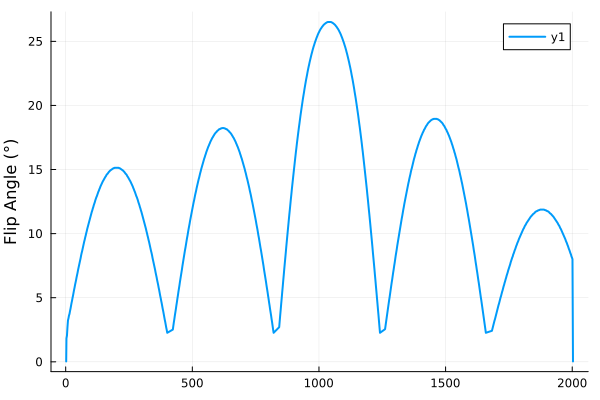

In [8]:
plot(rf_indices, fa_degrees,
    #xlabel="Event Index",
    ylabel="Flip Angle (°)",
    #title="Flip Angles from Nonzero RF Events",
    lw=2)